In [1]:
from typing import *
import os

import librosa
import numpy as np
from numpy.fft import rfft
from numpy import pi
from matplotlib import pyplot as plt
from IPython.display import Audio
import cmath
import scipy
from scipy.signal import stft
import torch
from torch import nn
import torch.nn.functional as F

from cache_no_hash import cache
from blindDescend import blindDescend
from yin import yin
from harmonicSynth import HarmonicSynth, Harmonic

TWO_PI = np.pi * 2

c:\ProgramData\Anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
os.chdir('..')
from shared import *
from lobe import getLobe
from manual_fc import ManualFC
os.chdir('playground')

We DON'T have CUDA.
Thanks to Belchenko, Kuppens, and Riley! 



In [3]:
def sino(freq, length):
    return np.sin(np.arange(length) * freq * TWO_PI / SR)

def playHard(data):
    return Audio(data, rate = SR)
def play(data, soft = .1):
    t = np.concatenate([data, [1]])
    length = round(soft * SR)
    t[:length ] = np.multiply(t[:length ], np.linspace(0, 1, length))
    t[-length:] = np.multiply(t[-length:], np.linspace(1, 0, length))
    return playHard(t)

def findPeaks(energy):
    slope = np.sign(energy[1:] - energy[:-1])
    extrema = slope[1:] - slope[:-1]
    return np.argpartition(
        (extrema == -2) * energy[1:-1], - N_HARMONICS,
    )[- N_HARMONICS:] + 1

def sft(signal, freq_bin):
    # Slow Fourier Transform
    return np.abs(np.sum(signal * np.exp(IMAGINARY_LADDER * freq_bin))) / PAGE_LEN

def refineGuess(guess, signal):
    def loss(x):
        if x < 0:
            return 0
        return - sft(signal, x)
    freq_bin, loss = blindDescend(loss, .01, .4, guess)
    return freq_bin * SR / PAGE_LEN, - loss

def widePlot(h = 3, w = 12):
    plt.gcf().set_size_inches(w, h)
    
def spectrum(signal, do_wide = True, trim = 130):
    energy = np.abs(rfft(signal * HANN)) / (PAGE_LEN / 2)
    X = np.linspace(0, SR / 2, len(energy))
    plt.plot(
        X     [:trim], 
        energy[:trim], 
    )
    plt.xlabel('freq (Hz)')
    if do_wide:
        widePlot()
    return energy

def spectrogram(signal, **kw):
    f, t, Zxx = stft(signal, fs=SR, **kw)
    plt.pcolormesh(t, f, np.abs(Zxx))

def concatSynth(synth, harmonics, n):
    buffer = []
    for i in range(n):
        synth.eat(harmonics)
        buffer.append(synth.mix())
    return np.concatenate(buffer)

def pitch2freq(pitch):
    return np.exp((pitch + 36.37631656229591) * 0.0577622650466621)

def freq2pitch(f):
    return np.log(f) * 17.312340490667562 - 36.37631656229591

def pagesOf(signal):
    for i in range(0, signal.size - PAGE_LEN + 1, PAGE_LEN):
        yield signal[i : i + PAGE_LEN]

def plotUnstretchedPartials(f0, n_partials = 14, color = 'r', alpha = .3):
    for i in range(1, n_partials + 1):
        freq = f0 * i
        plt.axvline(x = freq, color = color, alpha = alpha)


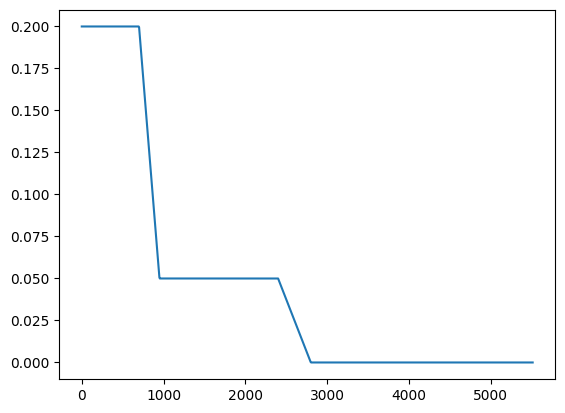

In [4]:
timbre_points = [
    (700, .2), 
    (950, .05), 
    (2400, .05), 
    (2800, 0), 
    (3000, 0), 
]
timbre = ManualFC(
    torch.tensor([x[0] for x in timbre_points]), 
    torch.tensor([x[1] for x in timbre_points]), 
)
X = torch.linspace(0, NYQUIST, 1000)
plt.plot(X, timbre(X))

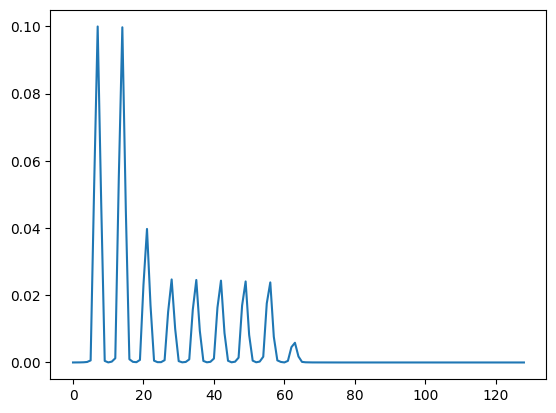

In [5]:
f0 = 300
lobe = getLobe()
y = []
for i in range(N_HARMONICS):
    freq = f0 * (i + 1)
    mag = timbre(torch.tensor(freq)).numpy()
    y.append(sino(freq, SR) * mag)
y_long = np.stack(y).sum(axis=0)
y = y_long[:PAGE_LEN]
energy = np.abs(rfft(y * HANN)) / (PAGE_LEN / 2)
energy = torch.tensor(energy).float()
plt.plot(energy)
play(y_long)

In [6]:
freqs = np.linspace(0, NYQUIST, SPECTRUM_SIZE)
freq_bin: float = freqs[1]
one_over_freq_bin = torch.tensor(1 / freq_bin).float()

In [7]:
freqCube = torch.arange(0, SPECTRUM_SIZE).float()
freqCube = freqCube.unsqueeze(0).repeat(N_HARMONICS, 1)
freqCube.shape

torch.Size([100, 129])

In [8]:
LADDER = torch.arange(0, N_HARMONICS).float().contiguous() + 1

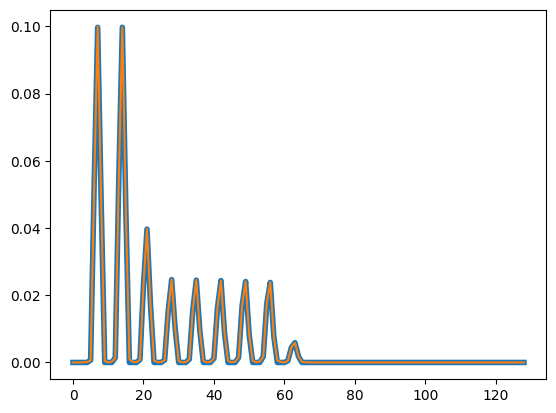

In [9]:
def forward(f0):
    freq = f0 * LADDER
    mag = timbre(freq)
    x = freqCube - (freq * one_over_freq_bin).unsqueeze(1)
    x = lobe(x)
    x = x * mag.unsqueeze(1)
    return x.sum(dim=0)

plt.plot(forward(f0), linewidth=4)
plt.plot(energy)

In [10]:
from itertools import count
from time import sleep

In [11]:
latent_f0 = torch.tensor(160.0, requires_grad=True)
optim = torch.optim.Adam([latent_f0], lr=1)
for epoch in range(10):
    spec_hat = forward(latent_f0)
    loss = F.mse_loss(spec_hat, energy)
    optim.zero_grad()
    loss.backward()
    optim.step()
    print(epoch, loss.item(), latent_f0.item())
    sleep(.5)

0 0.000428314640885219 159.00146484375
1 0.0004221021954435855 158.0078582763672
2 0.000416360649978742 157.0435333251953
3 0.00041040891665033996 156.07028198242188
4 0.00040227369754575193 155.0869598388672
5 0.0003927921352442354 154.09193420410156
6 0.00038136940565891564 153.0889129638672
7 0.00037030858220532537 152.07594299316406
8 0.0003596531751099974 151.06224060058594
9 0.00035260277218185365 150.09942626953125


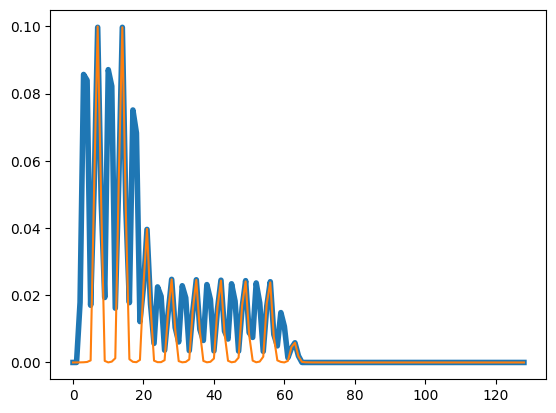

In [12]:
plt.plot(forward(latent_f0).detach(), linewidth=4)
plt.plot(energy)

Damn, we need multi-hot octave!

In [13]:
PRIMES = (2,3,5,7,11,13)
DREDGE_RADIUS = 2
DREDGE_MULT = torch.ones((DREDGE_RADIUS * 2 + 1, )).float()
for i in range(DREDGE_RADIUS):
    DREDGE_MULT[DREDGE_RADIUS - i - 1] = 1 / PRIMES[i]
    DREDGE_MULT[DREDGE_RADIUS + i + 1] = PRIMES[i]
DREDGE_MULT

tensor([0.3333, 0.5000, 1.0000, 2.0000, 3.0000])

In [14]:
FREQ_MULT = 1e2
class Dredge:
    def __init__(self, guess=200) -> None:
        self.freq = torch.tensor(
            float(guess / FREQ_MULT), 
            dtype=torch.float32, requires_grad=True, 
        )
        self.vector = torch.zeros(
            (DREDGE_RADIUS * 2 + 1, ), 
            dtype=torch.float32, 
        )
        self.vector[DREDGE_RADIUS] = 1
        self.vector.requires_grad = True
    
    def eval(self):
        return (DREDGE_MULT * self.freq * FREQ_MULT, self.vector)

    def simplify(self):
        old_vector = self.vector.detach()
        i = old_vector.argmax()
        if old_vector[i] / old_vector[DREDGE_RADIUS] < 2:
            return
        vector = torch.zeros(
            (DREDGE_RADIUS * 2 + 1, ), 
            dtype=torch.float32, 
        )
        vector[DREDGE_RADIUS] = old_vector[i]
        vector[DREDGE_RADIUS * 2 - i] = old_vector[DREDGE_RADIUS]
        vector.requires_grad = True
        self.vector = vector
        self.freq = self.freq.detach() * DREDGE_MULT[i]
        self.freq.requires_grad = True
    
    def parameters(self):
        return (self.freq, self.vector)

d = Dredge()
print(d.eval())
optim = torch.optim.Adam(d.parameters(), lr=1e-2)
for epoch in range(100):
    loss = (d.vector[4] - 0.8) ** 2 + (d.vector[3] - 0.1) ** 2
    optim.zero_grad()
    loss.backward()
    optim.step()
print(d.eval())
d.simplify()
print(d.eval())

(tensor([ 66.6667, 100.0000, 200.0000, 400.0000, 600.0000],
       grad_fn=<MulBackward0>), tensor([0., 0., 1., 0., 0.], requires_grad=True))
(tensor([ 66.6667, 100.0000, 200.0000, 400.0000, 600.0000],
       grad_fn=<MulBackward0>), tensor([0.0000, 0.0000, 1.0000, 0.0997, 0.7055], requires_grad=True))
(tensor([ 66.6667, 100.0000, 200.0000, 400.0000, 600.0000],
       grad_fn=<MulBackward0>), tensor([0.0000, 0.0000, 1.0000, 0.0997, 0.7055], requires_grad=True))


In [15]:
def trainDredge(dredge, ground_truth_energy, max_epoch=100, lr=1e-2):
    for epoch in range(max_epoch):
        if (epoch % 16 == 0):
            optim = torch.optim.Adam(dredge.parameters(), lr=lr)
            dredge.simplify()
        f0s, confidences = dredge.eval()
        spec_hat = []
        for i in range(f0s.shape[0]):
            spec_hat.append(forward(f0s[i]) * confidences[i])
        spec_hat = torch.stack(spec_hat, dim=0).sum(dim=0)
        loss = F.mse_loss(spec_hat, ground_truth_energy)
        optim.zero_grad()
        loss.backward()
        optim.step()
        yield epoch, loss, spec_hat

dredge = Dredge(450)
for epoch, loss, _ in trainDredge(dredge, energy):
    # print(epoch, loss.item())
    print(dredge.freq.item() * FREQ_MULT)
    print(dredge.vector)
    # sleep(.3)

449.0025997161865
tensor([ 0.0100, -0.0100,  0.9900,  0.0084, -0.0100], requires_grad=True)
449.6498107910156
tensor([ 0.0200, -0.0200,  0.9800,  0.0019, -0.0200], requires_grad=True)
450.3726005554199
tensor([ 0.0300, -0.0299,  0.9700,  0.0046, -0.0300], requires_grad=True)
450.62737464904785
tensor([ 0.0400, -0.0398,  0.9600,  0.0107, -0.0399], requires_grad=True)
450.4934787750244
tensor([ 0.0499, -0.0497,  0.9501,  0.0182, -0.0499], requires_grad=True)
450.2119541168213
tensor([ 0.0599, -0.0595,  0.9401,  0.0265, -0.0598], requires_grad=True)
449.94239807128906
tensor([ 0.0698, -0.0693,  0.9302,  0.0353, -0.0697], requires_grad=True)
449.8513698577881
tensor([ 0.0797, -0.0789,  0.9202,  0.0444, -0.0795], requires_grad=True)
449.98021125793457
tensor([ 0.0896, -0.0884,  0.9103,  0.0537, -0.0893], requires_grad=True)
450.2314567565918
tensor([ 0.0995, -0.0978,  0.9004,  0.0633, -0.0991], requires_grad=True)
450.4966735839844
tensor([ 0.1093, -0.1071,  0.8905,  0.0730, -0.1088], requi

In [16]:
y, sr = librosa.load('../dataset/dan.wav', sr=SR)
assert sr == SR
len(y)

655268

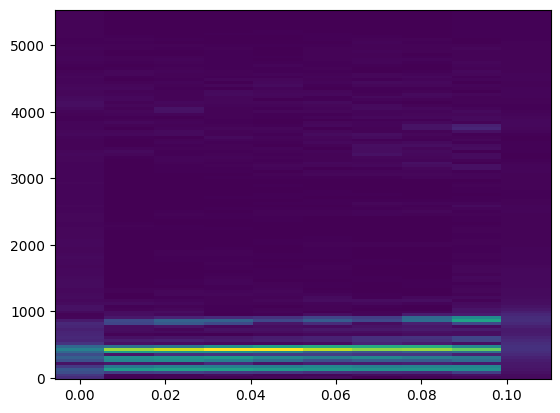

In [17]:
seg = y[7400:8500]
spectrogram(seg)
playHard(seg)

141.35148521336484
142.7628714056616
146.21058061993367
147.12401844487573


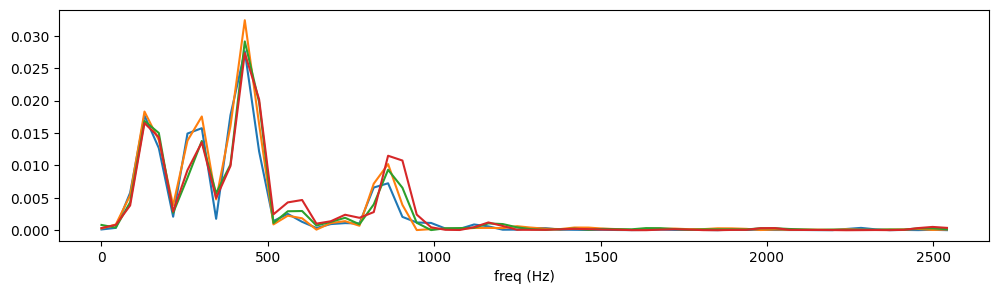

In [18]:
energies = []
for page in pagesOf(seg):
    f0 = yin(page, SR, PAGE_LEN)
    print(f0)
    energy = spectrum(page, trim=60)
    energies.append(torch.tensor(energy).float())

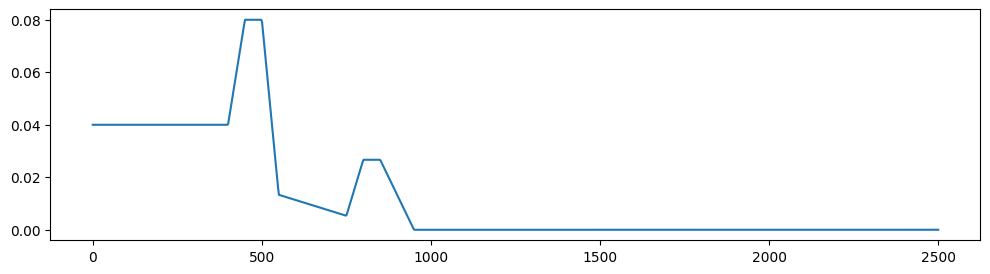

In [19]:
timbre_points = [
    (400, .015), 
    (450, .03), 
    (500, .03), 
    (550, 0.005), 
    (750, 0.002), 
    (800, .01), 
    (850, .01), 
    (950, 0), 
    (960, 0), 
]
timbre = ManualFC(
    torch.tensor([x[0] for x in timbre_points]), 
    torch.tensor([x[1] for x in timbre_points]) * 8 / 3, 
)
X = torch.linspace(0, 2500, 1000)
plt.plot(X, timbre(X))
widePlot()

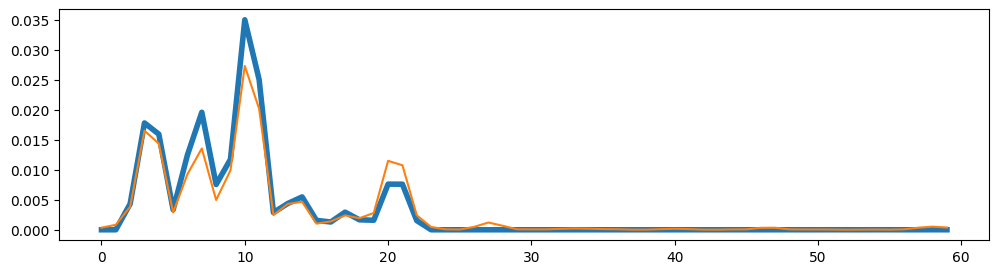

In [20]:
def forward(f0):
    freq = f0 * LADDER
    mag = timbre(freq)
    x = freqCube - (freq * one_over_freq_bin).unsqueeze(1)
    x = lobe(x)
    x = x * mag.unsqueeze(1)
    return x.sum(dim=0)

plt.plot(forward(f0)[:60], linewidth=4)
plt.plot(energy[:60])
widePlot()

In [21]:
pages = [*pagesOf(seg)]
dredges = [Dredge(100) for _ in pages]
spec_hats = [None] * len(pages)
hist_freq = [[] for _ in pages]
hist_conf = [[] for _ in pages]

In [22]:
def trainVoice(max_epoch=100):
    trainers = []
    for d, e in zip(dredges, energies):
        trainers.append(trainDredge(d, e, max_epoch, lr=2e-2))
    for epoch in range(max_epoch):
        print(epoch)
        for i, trainer in enumerate(trainers):
            _, loss, spec_hat = next(trainer)
            spec_hats[i] = spec_hat
            print(round(dredges[i].freq.item() * FREQ_MULT), end=', ')
            # print(d.vector)
            hist_freq[i].append(dredges[i].freq.detach().item())
            hist_conf[i].append(dredges[i].vector.detach().clone())
        print()

In [23]:
dredges = [Dredge(100) for _ in pages]
spec_hats = [None] * len(pages)
hist_freq = [[] for _ in pages]
hist_conf = [[] for _ in pages]
trainVoice(200)

0
98, 98, 98, 98, 
1
96, 96, 96, 96, 
2
94, 94, 94, 94, 
3
92, 92, 92, 92, 
4
90, 90, 90, 90, 
5
88, 88, 89, 89, 
6
87, 87, 88, 88, 
7
86, 86, 87, 87, 
8
85, 86, 87, 86, 
9
85, 86, 86, 86, 
10
85, 86, 87, 87, 
11
85, 86, 87, 87, 
12
86, 87, 88, 88, 
13
86, 87, 88, 88, 
14
87, 88, 89, 89, 
15
88, 89, 90, 90, 
16
90, 91, 92, 92, 
17
90, 90, 91, 91, 
18
90, 89, 90, 90, 
19
89, 89, 89, 89, 
20
88, 89, 89, 89, 
21
88, 89, 90, 89, 
22
88, 89, 90, 89, 
23
89, 90, 91, 90, 
24
89, 90, 91, 91, 
25
89, 90, 91, 91, 
26
89, 90, 90, 91, 
27
89, 90, 90, 90, 
28
89, 89, 89, 90, 
29
88, 89, 89, 89, 
30
88, 89, 89, 89, 
31
87, 88, 90, 89, 
32
89, 90, 92, 91, 
33
88, 89, 90, 90, 
34
87, 88, 89, 89, 
35
87, 88, 89, 89, 
36
87, 88, 89, 89, 
37
87, 88, 89, 89, 
38
88, 89, 90, 90, 
39
88, 90, 90, 90, 
40
88, 90, 91, 90, 
41
88, 90, 91, 90, 
42
87, 89, 90, 90, 
43
87, 89, 90, 89, 
44
87, 88, 89, 89, 
45
87, 88, 89, 89, 
46
87, 88, 89, 89, 
47
87, 88, 89, 90, 
48
85, 90, 91, 92, 
49
87, 89, 90, 90, 
50
88, 88,

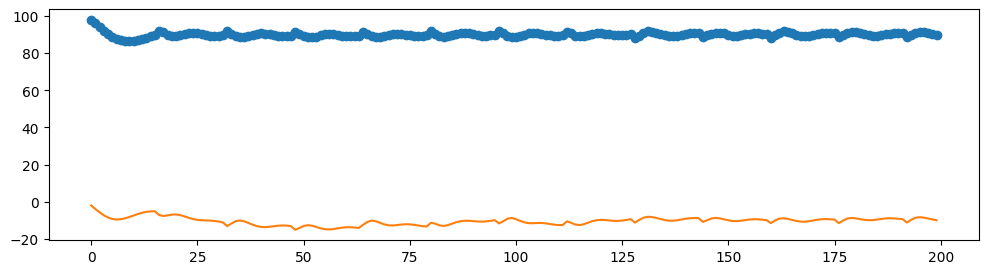

In [24]:
i = 2
plt.plot([x * FREQ_MULT for x in hist_freq[i]], 'o')
plt.plot([x[3] * 100 for x in hist_conf[i]])
widePlot()

(tensor([ 29.8494,  44.7741,  89.5482, 179.0963, 268.6445],
        grad_fn=<MulBackward0>),
 tensor([-0.0760, -0.1355,  1.0624, -0.0998, -0.2070], requires_grad=True))

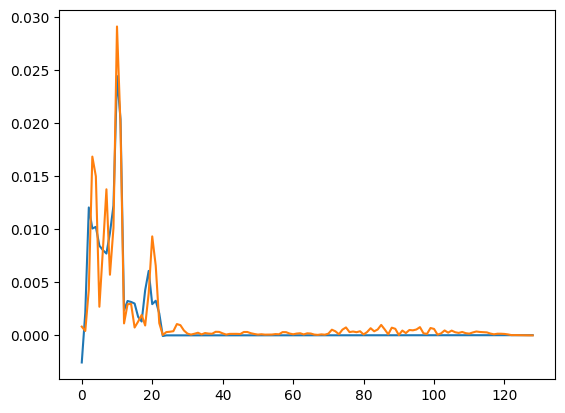

In [25]:
plt.plot(spec_hats[i].detach())
plt.plot(energies[i])
dredges[i].eval()
# dredges[i].vector.grad

for 3:2, it woudln't first / 3 then * 2. local min. 

In [26]:
RATIOS = [2, 3/2, 3]
DREDGE_RADIUS = len(RATIOS)
DREDGE_MULT = torch.ones((DREDGE_RADIUS * 2 + 1, )).float()
for i in range(DREDGE_RADIUS):
    DREDGE_MULT[DREDGE_RADIUS - i - 1] = 1 / RATIOS[i]
    DREDGE_MULT[DREDGE_RADIUS + i + 1] = RATIOS[i]
DREDGE_MULT

tensor([0.3333, 0.6667, 0.5000, 1.0000, 2.0000, 1.5000, 3.0000])

it works. now add regularization

In [33]:
def reguLoss(vector: torch.Tensor):
    loss = - vector.clip(max=0).sum()
    acc = torch.tensor(0).float()
    pos_v = vector.clip(min=0)
    de_pos_v = pos_v.detach()
    for i in range(vector.shape[0]):
        loss = loss + pos_v[i] * acc.clone()
        acc += de_pos_v[i]
    return loss

def trainDredge(dredge: Dredge, ground_truth_energy, max_epoch=100, lr=1e-2):
    for epoch in range(max_epoch):
        if (epoch % 16 == 0):
            optim = torch.optim.Adam(dredge.parameters(), lr=lr)
            dredge.simplify()
        f0s, confidences = dredge.eval()
        spec_hat = []
        for i in range(f0s.shape[0]):
            spec_hat.append(forward(f0s[i]) * confidences[i])
        spec_hat = torch.stack(spec_hat, dim=0).sum(dim=0)
        loss = F.mse_loss(spec_hat, ground_truth_energy)
        loss = loss + reguLoss(dredge.vector) * 1e-6
        optim.zero_grad()
        loss.backward()
        optim.step()
        yield epoch, loss, spec_hat


In [38]:
dredges = [Dredge(100) for _ in pages]
spec_hats = [None] * len(pages)
hist_freq = [[] for _ in pages]
hist_conf = [[] for _ in pages]
trainVoice(300)

0
98, 98, 98, 98, 
1
96, 96, 96, 96, 
2
94, 94, 94, 94, 
3
92, 92, 92, 92, 
4
90, 90, 90, 90, 
5
88, 88, 89, 89, 
6
87, 87, 87, 87, 
7
86, 86, 87, 87, 
8
85, 86, 86, 86, 
9
85, 86, 86, 86, 
10
85, 87, 87, 86, 
11
86, 87, 87, 87, 
12
86, 88, 88, 88, 
13
87, 89, 88, 89, 
14
88, 90, 89, 89, 
15
89, 91, 90, 90, 
16
91, 89, 92, 92, 
17
90, 90, 91, 91, 
18
89, 91, 90, 89, 
19
89, 92, 90, 89, 
20
90, 92, 90, 90, 
21
91, 91, 91, 91, 
22
91, 90, 91, 92, 
23
91, 90, 92, 92, 
24
91, 90, 91, 92, 
25
91, 90, 91, 91, 
26
90, 91, 91, 91, 
27
90, 92, 90, 90, 
28
90, 92, 90, 90, 
29
91, 92, 90, 90, 
30
92, 92, 91, 90, 
31
92, 92, 91, 90, 
32
90, 90, 89, 92, 
33
91, 91, 91, 91, 
34
92, 92, 92, 89, 
35
92, 93, 93, 90, 
36
92, 93, 93, 91, 
37
92, 93, 92, 91, 
38
91, 92, 92, 92, 
39
91, 91, 91, 92, 
40
91, 91, 91, 92, 
41
91, 91, 90, 92, 
42
92, 91, 91, 91, 
43
92, 92, 91, 91, 
44
92, 92, 91, 90, 
45
92, 92, 92, 90, 
46
92, 93, 92, 90, 
47
92, 92, 92, 91, 
48
90, 90, 90, 93, 
49
91, 92, 91, 91, 
50
93, 93,

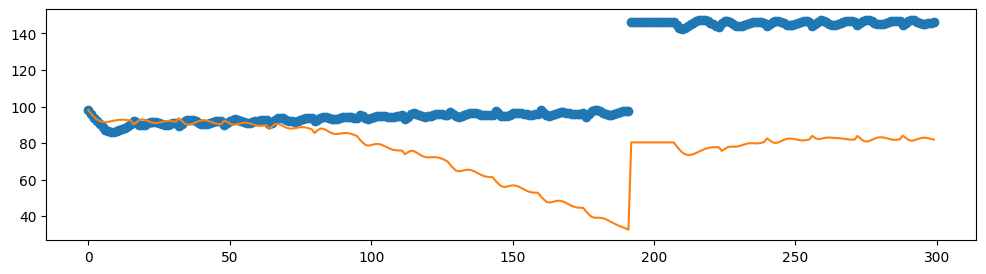

In [46]:
i = 2
plt.plot([x * FREQ_MULT for x in hist_freq[i]], 'o')
plt.plot([x[3] * 100 for x in hist_conf[i]])
widePlot()

In [41]:
for d in dredges:
    print(d.eval())

(tensor([ 47.2201,  94.4402,  70.8301, 141.6603, 283.3205, 212.4904, 424.9808],
       grad_fn=<MulBackward0>), tensor([-0.0446,  0.1284,  0.0084,  0.8884, -0.0245, -0.0125,  0.0042],
       requires_grad=True))
(tensor([ 47.8802,  95.7603,  71.8202, 143.6405, 287.2810, 215.4607, 430.9214],
       grad_fn=<MulBackward0>), tensor([ 0.0081,  0.0179,  0.0076,  0.9465, -0.0244,  0.0105,  0.0178],
       requires_grad=True))
(tensor([ 48.8061,  97.6122,  73.2091, 146.4183, 292.8366, 219.6274, 439.2549],
       grad_fn=<MulBackward0>), tensor([-2.6731e-03,  1.0832e-04,  4.3075e-05,  8.1955e-01, -2.4562e-02,
        -2.4322e-05,  1.2161e-02], requires_grad=True))
(tensor([ 48.6193,  97.2386,  72.9289, 145.8579, 291.7158, 218.7868, 437.5737],
       grad_fn=<MulBackward0>), tensor([-2.3562e-02,  8.8427e-02, -3.4416e-04,  7.7901e-01, -2.9470e-03,
         2.1903e-03,  1.8027e-03], requires_grad=True))
